<a href="https://www.kaggle.com/code/adnanzamanniloy/stroke-risk-xgboost-smote-shap?scriptVersionId=249957026" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install --quiet --upgrade scikit-learn imblearn shap xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 13.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 4.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 58.9 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.6.1 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             roc_curve, precision_recall_curve, auc)

from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

import shap  
shap.initjs()

## Load data

In [3]:
df = pd.read_csv('/kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv')

print(df.head())
print(df.info())


      id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 e

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


## Basic preprocessing

In [4]:
print(df.isnull().sum())

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64


## fill missing BMI

In [5]:

df['bmi'] = df['bmi'].fillna(df['bmi'].median())

## Encode categorical variables

In [6]:
categorical_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])


## Drop irrelevant column

In [7]:

df = df.drop(['id'], axis=1)

## Features & Target

In [8]:
X = df.drop('stroke', axis=1)
y = df['stroke']


## Train/Test Split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

In [10]:
print("Before SMOTE:")
print(y_train.value_counts())

Before SMOTE:
stroke
0    3889
1     199
Name: count, dtype: int64


## SMOTE for imbalance

In [11]:
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("After SMOTE:")
print(y_train_res.value_counts())

After SMOTE:
stroke
0    3889
1    3889
Name: count, dtype: int64


##  Scale features

In [12]:
scaler = StandardScaler()
X_train_res_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)


## Train XGBoost with tuning

In [13]:
model = XGBClassifier(
    scale_pos_weight = len(y_train[y_train==0]) / len(y_train[y_train==1]),
    use_label_encoder=False,
    eval_metric='auc',
    random_state=42
)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(model, param_grid, scoring='roc_auc', cv=cv, verbose=1, n_jobs=-1)
grid.fit(X_train_res_scaled, y_train_res)

print("Best parameters:", grid.best_params_)
print("Best CV AUC:", grid.best_score_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [11:40:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [11:40:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [11:40:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [11:40:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [11:40:41] WARNING: /w

Best parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
Best CV AUC: 0.9917775955870471


## Evaluate on Test Set

In [14]:
y_probs = grid.predict_proba(X_test_scaled)[:,1]
roc_auc = roc_auc_score(y_test, y_probs)

print(f"Test ROC AUC: {roc_auc:.4f}")


Test ROC AUC: 0.7757


## Find best threshold by PR-AUC or F1

In [15]:
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
pr_auc = auc(recall, precision)
print(f"Test PR AUC: {pr_auc:.4f}")

Test PR AUC: 0.1238


## Plot ROC

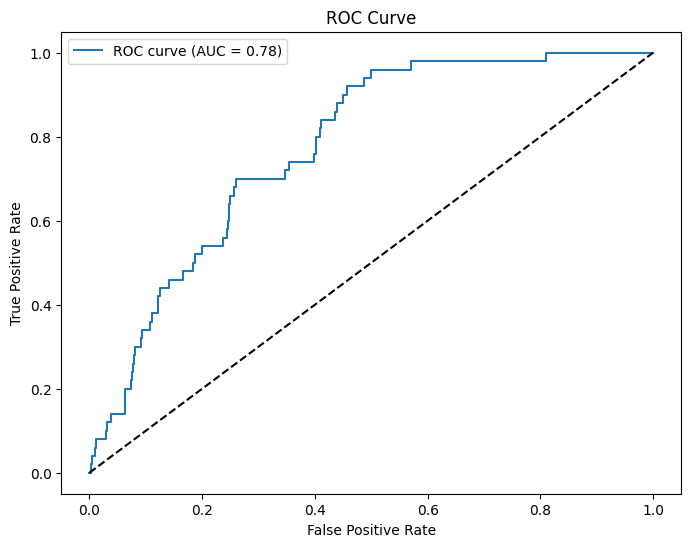

In [16]:
fpr, tpr, _ = roc_curve(y_test, y_probs)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

## Plot Precision-Recall

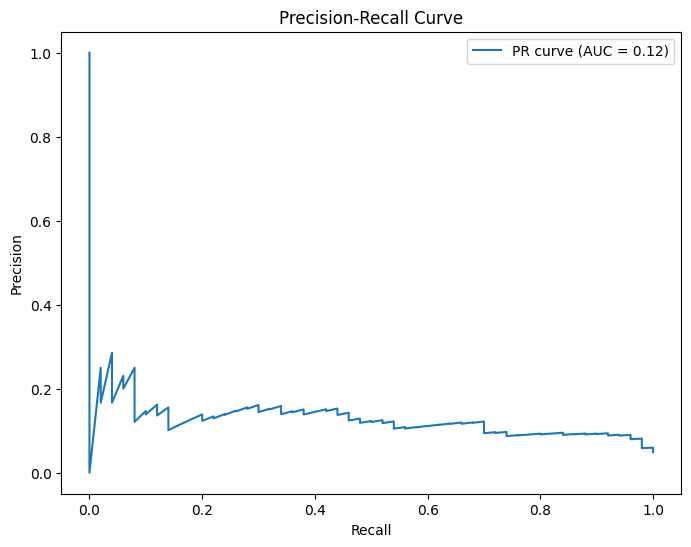

In [17]:
plt.figure(figsize=(8,6))
plt.plot(recall, precision, label=f'PR curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

## Find best threshold

In [18]:
f1_scores = 2 * (precision * recall) / (precision + recall)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"Best Threshold: {best_threshold:.4f}, Best F1: {f1_scores[best_idx]:.4f}")

y_pred = (y_probs >= best_threshold).astype(int)

print(classification_report(y_test, y_pred))

Best Threshold: 0.9944, Best F1: nan
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       972
           1       0.00      0.00      0.00        50

    accuracy                           0.95      1022
   macro avg       0.48      0.50      0.49      1022
weighted avg       0.90      0.95      0.93      1022



/tmp/ipykernel_36/2361387024.py:1: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


## Confusion matrix

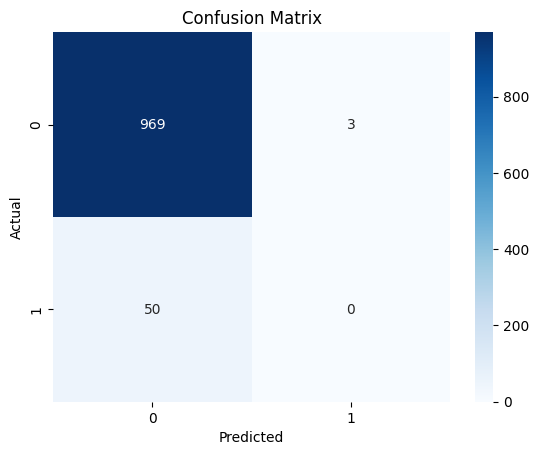

In [19]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## SHAP for feature importance

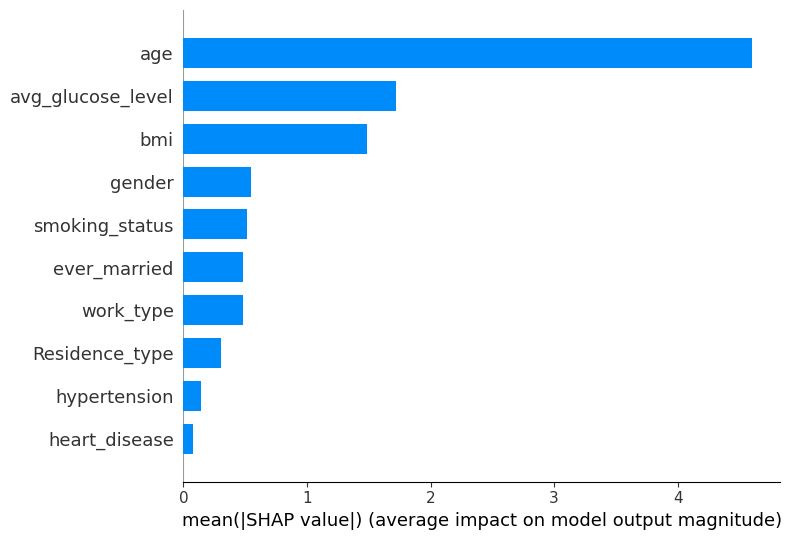

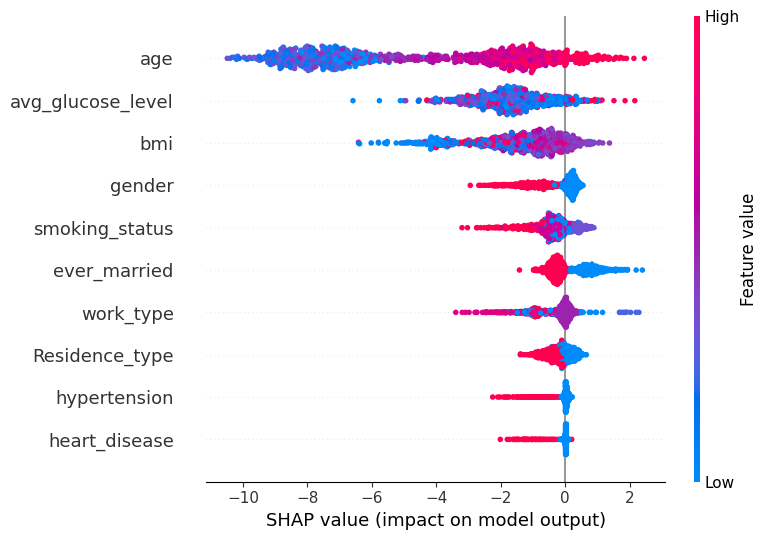

In [20]:
explainer = shap.TreeExplainer(grid.best_estimator_)
shap_values = explainer.shap_values(X_test_scaled)

shap.summary_plot(shap_values, X_test, plot_type="bar")
shap.summary_plot(shap_values, X_test)